In [2]:
from scipy.io import loadmat
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import ipdb

In [3]:
data_dir = '/media/data_cifs_lrs/projects/prj_synchrony/data/BSR/BSDS500/data'
mat = np.squeeze(loadmat(os.path.join(data_dir, 'groundTruth/train/41004.mat'))['groundTruth'])
img = imread(os.path.join(data_dir, 'images/train/41004.jpg'))
segs = []
cts = []
for i in range(mat.shape[0]):
    segs.append(mat[i][0][0][0])
    cts.append(mat[i][0][0][1])

(26, 40)


(-0.5, 39.5, 25.5, -0.5)

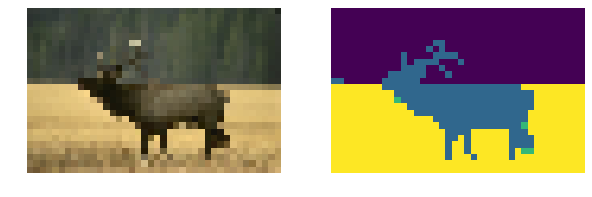

In [5]:
import cv2 as cv
h, w, _ = img.shape
s = 12
sm_img = cv.resize(img, (w//s, h//s))
sm_seg = cv.resize(segs[2], (w//s, h//s))
print(sm_seg.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 30))
axes[0].imshow(sm_img)
axes[1].imshow(sm_seg)
axes[0].axis('off')
axes[1].axis('off')



In [6]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [12]:
# #import ipdb
# def circular_moments(phases, masks, split=False, burn_in_prop=.5):
#     """
#     phases: shape [steps, ...]
#     masks(one hot indicator): shape [num_groups, ...]
#     split: if return synch and desynch separately
#     burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
#     """
    
#     num_groups = masks.shape[0]
#     group_size = masks.sum(1)
#     group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
#     T = phases.shape[0]
    
#     burn_in_steps = int(burn_in_prop * T) - 1
#     masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
#     xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
#     yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
#     go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
#     synch = 1 - go.sum(-1)/num_groups

#     mean_xx = xx.sum(-1) / group_size
#     mean_yy = yy.sum(-1) / group_size
#     mean_angles = torch.atan2(mean_yy, mean_xx)
#     desynch = 0
#     for m in np.arange(1, int(np.floor(num_groups/2.))+1):
# #         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
#         desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    
#     loss = synch + desynch
    
#     if split == True:
#         return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
#     else:
#         return loss[burn_in_steps:,...].mean()

def circular_moments_batch(phases, masks,split = False):
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]

    #burn_in_steps = int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(1) * masks.unsqueeze(0)
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups
    mean_angles = torch.atan2(yy.sum(-1),xx.sum(-1))
    desynch = 0
    for m in np.arange(1, int(np.floor(num_groups/2.))+1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)

    loss = (synch + desynch)
    if split == True:
        return loss.mean(), synch.mean(), desynch.mean()
    else:
        return loss.mean()

In [13]:
#import ipdb
def cohn_loss(phases, masks, split=False, burn_in_prop=.5):
    """
    phases: shape [steps, ...]
    masks(one hot indicator): shape [num_groups, ...]
    split: if return synch and desynch separately
    burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
    """
    
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T) - 1
    masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_xx = xx.sum(-1) / group_size
    mean_yy = yy.sum(-1) / group_size
    mean_angles = torch.atan2(mean_yy, mean_xx)
    phase_diffs = (mean_angles.unsqueeze(3) - mean_angles.unsqueeze(2))
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + 1e-5)) + np.log(2)).sum((1,2,3)) / (num_groups)**2
    
    loss = synch + desynch
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

In [21]:
class coupling_net_minju(torch.nn.Module):
    def __init__(self, feature_dim, num_hid_units=256, kernel_size = 3,symmetric=False,
                 preprocessing=False):
        """
        Take in a set of embeddings of nodes and produce link weights. Weights will be produced separately, only the embeddings of two correponding nodes will be considered. Like relational networks.
        input: shape [batch_size, feature_dim]
        coupling(normalized unsymmetric): shape [batch_size, batch_size]
        """
        super(coupling_net_minju, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=kernel_size, padding=kernel_size-4),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, feature_dim, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
        )
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2*(feature_dim+2), num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_hid_units, num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_hid_units,1,bias=False)
        )
        self.symmetric=symmetric
        self.preprocessing = preprocessing
#         self.w=w#120
#         self.h=h#80
#         self.register_buffer('xx', torch.Tensor(np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[None,None,:,:] / w))
#         self.register_buffer('yy', torch.Tensor(np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[None,None,:,:] / h))
#         self.register_buffer('mask', torch.randperm(self.w * self.h))

    def forward(self, x, w, h, alpha=0.1, burnin_steps=150, num_steps=50, init_phase = None,
                subset_size=128, enable_noise=False, record_trajectory=True, record_loss=True,
                labels=None, record_couplings=False):
        if init_phase is None:
            init_phase = torch.rand((w * h,)).float().unsqueeze(0).to(device) * 2 * np.pi
        self.xx = torch.Tensor(np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[None,None,:,:] / w).to(device)
        self.yy = torch.Tensor(np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[None,None,:,:] / h).to(device)
    
        if self.preprocessing:
            x = self.features(x)
        if enable_noise:
            x = torch.zeros_like(x)
        x = torch.cat([x, self.xx, self.yy],dim=1)
        b, c, h, w = x.size()
        x = x.view(b,c,-1)
    
#         Bx2 --> (bXb)x4 --> (bxb)x1 --> bxb
        self.dyn_loss = []
        self.coupling_subset = []
        self.mask_subset = []
        self.x_subset = []
        subset_counter = 0
        with torch.no_grad():
            phase = init_phase
            for t in range(burnin_steps):
                mask = torch.randperm(w * h)[:subset_size].to(device).detach()
#                 mask = torch.tensor(np.arange(w*h,)).to(device)
                _x = torch.index_select(x,2,mask)
                if record_couplings:
                    if subset_counter <=10:            
                        self.x_subset.append(_x[:,0,...].unsqueeze(-2) - _x[:,0,...].unsqueeze(-1))
                        self.mask_subset.append(_x[:,3:,...].unsqueeze(-2) - _x[:,3:,...].unsqueeze(-1))

                _x = _x.permute(0,2,1).view(-1, c)
                batch_size = _x.shape[0]
                _x = torch.cat([_x[:,None].repeat(1,batch_size,1), _x[None,:].repeat(batch_size,1,1)],dim=2)

                #Infer couplings 
                coupling = self.layers(_x.view(-1, _x.shape[-1])).squeeze().reshape(batch_size, batch_size)
                coupling = torch.nn.functional.normalize(coupling, p=2, dim=1)
                if self.symmetric:
                    coupling = .5 * (coupling + coupling.transpose(1,0))

#                 self.coupling_density += torch.histc(coupling.reshape(-1).cpu(),bins=100000,min=-.5,max=.5) / (subset_size**2)
                if record_couplings:
                    if subset_counter <=10:
                        self.coupling_subset.append(coupling)
                        subset_counter += 1
                _phase = torch.index_select(phase,1,mask)[0]

    #             phase_diffs = torch.sin(_phase.unsqueeze(-1) - _phase.unsqueeze(-2))
                phase_diffs = torch.matmul(coupling, torch.sin(_phase).unsqueeze(1)).squeeze(1) * torch.cos(_phase)\
                        - torch.matmul(coupling, torch.cos(_phase).unsqueeze(1)).squeeze(1) * torch.sin(_phase)

                delta = alpha * phase_diffs
                phase.index_add_(1, mask, delta.unsqueeze(0))
            
                if record_loss:
                    loss, synch, desynch = cohn_loss(phase.view(b, 1, -1), labels, burn_in_prop=0, split=True)
                    self.dyn_loss.append(loss.detach().cpu().numpy())
            
        if record_trajectory:
            phase_flow = [phase]
        else:
            last_phase = phase
        for t in range(num_steps):
#             mask = torch.tensor(np.arange(w*h,)).to(device)

            mask = torch.randperm(w * h)[:subset_size].to(device).detach()
#             for i in range(0,2400,200):
#             mask = self.mask[i:i+200]
#             print(cnt)
#             cnt+=1

            _x = torch.index_select(x,2,mask)
            _x = _x.permute(0,2,1).view(-1, c)
            batch_size = _x.shape[0]
            _x = torch.cat([_x[:,None].repeat(1,batch_size,1), _x[None,:].repeat(batch_size,1,1)],dim=2)

            #Infer couplings 
            coupling = self.layers(_x.view(-1, _x.shape[-1])).squeeze().reshape(batch_size, batch_size)
#             coupling = torch.nn.functional.normalize(coupling, p=2, dim=1)
#             self.coupling_density += torch.histc(coupling.reshape(-1).cpu(),bins=100000,min=-.5,max=.5) / (subset_size**2)

            if self.symmetric:
                coupling = .5 * (coupling + coupling.transpose(1,0))

            if record_trajectory:
                phase = phase_flow[-1].clone()
            else:
                phase = last_phase

            _phase = torch.index_select(phase,1,mask)[0]
            
#             phase_diffs = torch.sin(_phase.unsqueeze(-1) - _phase.unsqueeze(-2))
            phase_diffs = torch.matmul(coupling, torch.sin(_phase).unsqueeze(1)).squeeze(1) * torch.cos(_phase)\
                    - torch.matmul(coupling, torch.cos(_phase).unsqueeze(1)).squeeze(1) * torch.sin(_phase)
            
            delta = alpha * phase_diffs
            phase.index_add_(1, mask, delta.unsqueeze(0))
            if record_trajectory:
                phase_flow.append(phase)
            else:
                last_phase = phase
            if record_loss:    
                loss, synch, desynch = cohn_loss(phase.view(b, 1, -1), labels, burn_in_prop=0, split=True)
                self.dyn_loss.append(loss.detach().cpu().numpy())
#         self.coupling_density /= (burnin_steps + num_steps)
        if record_trajectory:    
            phase_flow = torch.stack(phase_flow[1:])
            _phase_flow = phase_flow.view(phase_flow.shape[0], 1, h, w)
            return _phase_flow
        else:
            return phase
#         _phase_flow = torch.cat([torch.cos(_phase_flow), torch.sin(_phase_flow)],dim=1)
#         return self.decoder(_phase_flow), phase_flow

In [8]:
def phase_evol_ax(ax, phases, masks=None, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[0]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
        ax.set_ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            ax.set_plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')

In [9]:
from sklearn.preprocessing import LabelBinarizer

# h, w = segs[2].shape
# sm_seg = cv.resize(segs[2], (w//8, h//8), cv.INTER_NEAREST)

# plt.figure()
# plt.imshow((sm_seg==2).astype(float))

print(np.unique(sm_seg))
lb = LabelBinarizer()
label = sm_seg.reshape(-1)
label_bin = lb.fit_transform(label)

label_bin[:,2]=0
label_bin = np.concatenate([label_bin[:,:2], label_bin[:,3:]],axis=1)

# print(label_bin.shape)
# plt.figure()
# plt.imshow(label_bin.reshape(40,60,3)[:,:,0])
# plt.figure()
# plt.imshow(label_bin.reshape(40,60,3)[:,:,1])
# plt.figure()
# plt.imshow(label_bin.reshape(40,60,3)[:,:,2])
# h, w, _ = sm_img.shape
# xx = np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[:,:,None] / w
# yy = np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[:,:,None] / h

# x = torch.Tensor(np.concatenate([sm_img, xx, yy], axis=2)).to(device) / 255.
x = torch.Tensor(sm_img).to(device) / 255.
y = torch.Tensor(label_bin).to(device)
x = x.permute(2,0,1).unsqueeze(0)
y = y.transpose(0,1)

print(y.shape)

[1 2 3 4]
torch.Size([3, 1040])


In [28]:
seed=10
np.random.seed(seed)
torch.manual_seed(seed)
pretrained = False
symmetric=False
alpha = 0.2#0.2
subset_size=100
burnin_steps=200#150
num_steps=50
num_epochs = 500
lr = 1e-4
net = coupling_net_minju(feature_dim=3, num_hid_units=128, kernel_size=7,
                         symmetric=symmetric, preprocessing=False).to(device)
if pretrained:
    net.load_state_dict(torch.load('/media/data_cifs/projects/prj_synchrony/results/models/gray_elk_net.pt'))
optim = torch.optim.Adam(net.parameters(), lr=lr)
x_gray = x.mean(1).unsqueeze(1).repeat(1,3,1,1)

In [11]:
phases = net(x_gray, h=8, w=12, alpha=alpha, burnin_steps=burnin_steps,
                 num_steps=num_steps, subset_size=subset_size, enable_noise=False, record_loss=False, record_couplings=True)

print(phases.mean())

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 8 and 40 in dimension 2 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71

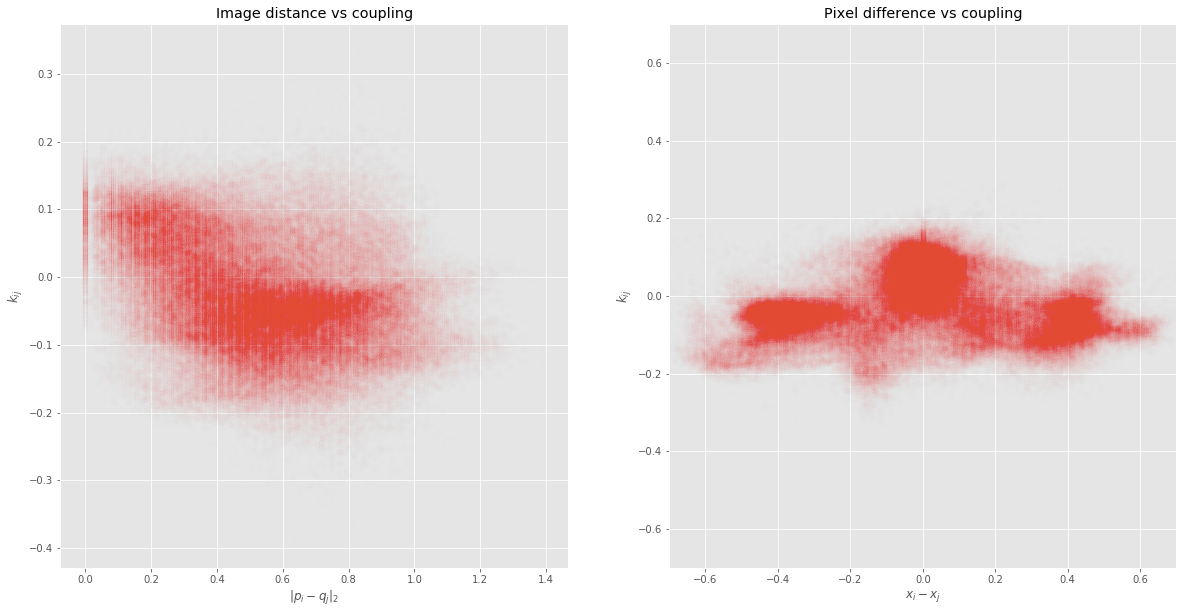

In [83]:
couplings = torch.stack(net.coupling_subset).reshape(-1,).cpu().numpy()
dists = torch.sqrt(torch.stack(net.mask_subset)[:,:,0,...]**2 + torch.stack(net.mask_subset)[:,:,1,...]**2).reshape(-1,).cpu().numpy()
pixels = torch.stack(net.x_subset).reshape(-1).cpu().numpy()

fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(dists, couplings, alpha=.005)
axes[0].set_xlabel(r'$\|p_i - q_j \|_2$')
axes[0].set_title('Image distance vs coupling')
axes[0].set_ylabel(r'$k_{ij}$')
axes[1].scatter(pixels, couplings, alpha=.005)
axes[1].set_xlabel(r'$x_i - x_j$')
axes[1].set_ylabel(r'$k_{ij}$')
axes[1].set_title('Pixel difference vs coupling')
axes[1].set_xlim([-.7,.7])
axes[1].set_ylim([-.7,.7])
plt.show()
plt.close()

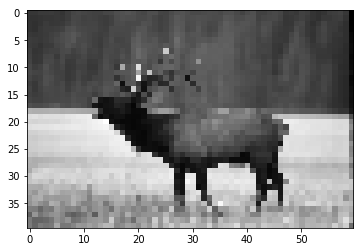

In [22]:
plt.imshow(x_gray.cpu().squeeze()[0,...], cmap=plt.get_cmap('gray'))
plt.show()

0 tensor(0.5276, device='cuda:4', grad_fn=<DivBackward0>) 62.4641074206143


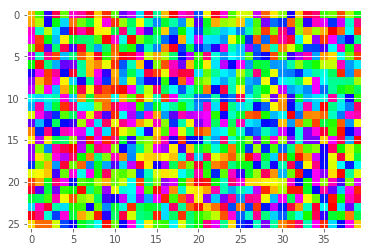

1 tensor(0.4088, device='cuda:4', grad_fn=<DivBackward0>) 26.189040961215724
2 tensor(0.4877, device='cuda:4', grad_fn=<DivBackward0>) 154.7674434736045
3 tensor(0.4432, device='cuda:4', grad_fn=<DivBackward0>) 529.9275692994828
4 tensor(0.4483, device='cuda:4', grad_fn=<DivBackward0>) 103.33463528241337
5 tensor(0.4186, device='cuda:4', grad_fn=<DivBackward0>) 61.41962308035046
6 tensor(0.4699, device='cuda:4', grad_fn=<DivBackward0>) 50.36816608460338
7 tensor(0.4129, device='cuda:4', grad_fn=<DivBackward0>) 527.6090919461438
8 tensor(0.4226, device='cuda:4', grad_fn=<DivBackward0>) 42.38496962406805
9 tensor(0.5264, device='cuda:4', grad_fn=<DivBackward0>) 67.78546567097744
10 tensor(0.4004, device='cuda:4', grad_fn=<DivBackward0>) 15.78121046308051
11 tensor(0.4473, device='cuda:4', grad_fn=<DivBackward0>) 176.39364711708666
12 tensor(0.3765, device='cuda:4', grad_fn=<DivBackward0>) 18.217302836516218
13 tensor(0.3800, device='cuda:4', grad_fn=<DivBackward0>) 26.623646209946212
14 

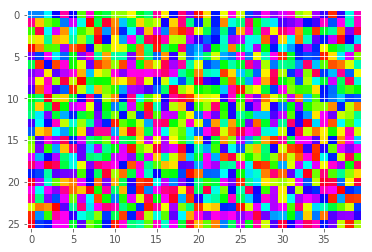

26 tensor(0.4295, device='cuda:4', grad_fn=<DivBackward0>) 43.37181389171336
27 tensor(0.5783, device='cuda:4', grad_fn=<DivBackward0>) 228.86257695650033
28 tensor(0.4830, device='cuda:4', grad_fn=<DivBackward0>) 74.11481075410045
29 tensor(0.4008, device='cuda:4', grad_fn=<DivBackward0>) 12.631018312110138
30 tensor(0.4602, device='cuda:4', grad_fn=<DivBackward0>) 33.74979000796914
31 tensor(0.4327, device='cuda:4', grad_fn=<DivBackward0>) 49.44741713776945
32 tensor(0.4337, device='cuda:4', grad_fn=<DivBackward0>) 8.317894060570787
33 tensor(0.4287, device='cuda:4', grad_fn=<DivBackward0>) 8.452597847743316
34 tensor(0.4046, device='cuda:4', grad_fn=<DivBackward0>) 13.837089269820387
35 tensor(0.4418, device='cuda:4', grad_fn=<DivBackward0>) 15.328214397942963
36 tensor(0.5672, device='cuda:4', grad_fn=<DivBackward0>) 47.697587516478954
37 tensor(0.6777, device='cuda:4', grad_fn=<DivBackward0>) 24.58471722036911
38 tensor(0.3633, device='cuda:4', grad_fn=<DivBackward0>) 6.4656671570

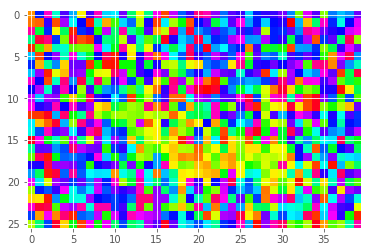

51 tensor(0.4356, device='cuda:4', grad_fn=<DivBackward0>) 10.73553401778043
52 tensor(0.4946, device='cuda:4', grad_fn=<DivBackward0>) 34.35822731393373
53 tensor(0.3908, device='cuda:4', grad_fn=<DivBackward0>) 12.445064999023476
54 tensor(0.3912, device='cuda:4', grad_fn=<DivBackward0>) 8.68931562022577
55 tensor(0.4289, device='cuda:4', grad_fn=<DivBackward0>) 10.597194699554935
56 tensor(0.3903, device='cuda:4', grad_fn=<DivBackward0>) 9.627791719179722
57 tensor(0.3932, device='cuda:4', grad_fn=<DivBackward0>) 3.1478329075625187
58 tensor(0.3368, device='cuda:4', grad_fn=<DivBackward0>) 2.5155680745129763
59 tensor(0.4619, device='cuda:4', grad_fn=<DivBackward0>) 19.065468585135463
60 tensor(0.4160, device='cuda:4', grad_fn=<DivBackward0>) 6.331108632843977
61 tensor(0.3737, device='cuda:4', grad_fn=<DivBackward0>) 5.504106542272635
62 tensor(0.3586, device='cuda:4', grad_fn=<DivBackward0>) 4.846143009779971
63 tensor(0.3815, device='cuda:4', grad_fn=<DivBackward0>) 3.68935958914

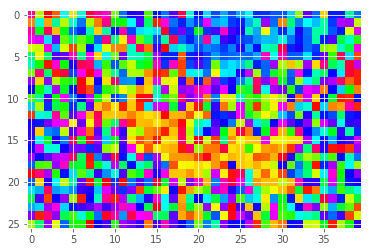

76 tensor(0.3346, device='cuda:4', grad_fn=<DivBackward0>) 1.7799943872046222
77 tensor(0.3538, device='cuda:4', grad_fn=<DivBackward0>) 3.153165143813499
78 tensor(0.3198, device='cuda:4', grad_fn=<DivBackward0>) 3.6553054163917698
79 tensor(0.3257, device='cuda:4', grad_fn=<DivBackward0>) 1.9314059491332367
80 tensor(0.2972, device='cuda:4', grad_fn=<DivBackward0>) 3.0801394852202773
81 tensor(0.3212, device='cuda:4', grad_fn=<DivBackward0>) 6.49316436354217
82 tensor(0.3282, device='cuda:4', grad_fn=<DivBackward0>) 3.8133889666316416
83 tensor(0.2961, device='cuda:4', grad_fn=<DivBackward0>) 2.8136136284577407
84 tensor(0.3151, device='cuda:4', grad_fn=<DivBackward0>) 6.276555197780355
85 tensor(0.3389, device='cuda:4', grad_fn=<DivBackward0>) 4.196967702457095
86 tensor(0.3429, device='cuda:4', grad_fn=<DivBackward0>) 6.322225122110989
87 tensor(0.2885, device='cuda:4', grad_fn=<DivBackward0>) 3.6223441821327866
88 tensor(0.2994, device='cuda:4', grad_fn=<DivBackward0>) 4.922223381

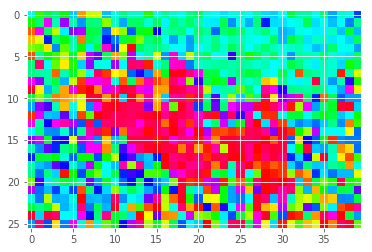

101 tensor(0.2985, device='cuda:4', grad_fn=<DivBackward0>) 2.902662064525681
102 tensor(0.2713, device='cuda:4', grad_fn=<DivBackward0>) 2.7019151989411685
103 tensor(0.2668, device='cuda:4', grad_fn=<DivBackward0>) 2.3860001127411543
104 tensor(0.2551, device='cuda:4', grad_fn=<DivBackward0>) 2.6664519208998594
105 tensor(0.2724, device='cuda:4', grad_fn=<DivBackward0>) 2.55393361419586
106 tensor(0.2662, device='cuda:4', grad_fn=<DivBackward0>) 3.019888920624107
107 tensor(0.2667, device='cuda:4', grad_fn=<DivBackward0>) 3.473796175615685
108 tensor(0.2621, device='cuda:4', grad_fn=<DivBackward0>) 2.7793201816421065
109 tensor(0.2478, device='cuda:4', grad_fn=<DivBackward0>) 2.254072066556979
110 tensor(0.2564, device='cuda:4', grad_fn=<DivBackward0>) 4.076885592744509
111 tensor(0.2616, device='cuda:4', grad_fn=<DivBackward0>) 3.7760215672677075
112 tensor(0.2362, device='cuda:4', grad_fn=<DivBackward0>) 2.8273960718583697
113 tensor(0.2658, device='cuda:4', grad_fn=<DivBackward0>)

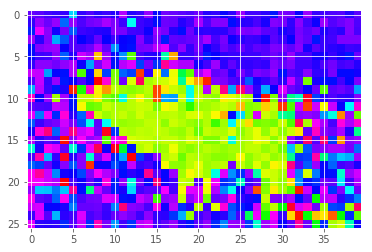

126 tensor(0.2013, device='cuda:4', grad_fn=<DivBackward0>) 3.7740727511273824
127 tensor(0.1977, device='cuda:4', grad_fn=<DivBackward0>) 4.160499626263707
128 tensor(0.2017, device='cuda:4', grad_fn=<DivBackward0>) 3.1630731378426282
129 tensor(0.2390, device='cuda:4', grad_fn=<DivBackward0>) 4.092722017700606
130 tensor(0.2367, device='cuda:4', grad_fn=<DivBackward0>) 3.757172585336335
131 tensor(0.1671, device='cuda:4', grad_fn=<DivBackward0>) 3.8158870093670867
132 tensor(0.1740, device='cuda:4', grad_fn=<DivBackward0>) 4.379120796746437
133 tensor(0.1722, device='cuda:4', grad_fn=<DivBackward0>) 3.5399225486974304
134 tensor(0.1631, device='cuda:4', grad_fn=<DivBackward0>) 2.116775237448217
135 tensor(0.1741, device='cuda:4', grad_fn=<DivBackward0>) 2.8315231349286565
136 tensor(0.1727, device='cuda:4', grad_fn=<DivBackward0>) 2.5154869941147293
137 tensor(0.1636, device='cuda:4', grad_fn=<DivBackward0>) 1.555161040168815
138 tensor(0.1643, device='cuda:4', grad_fn=<DivBackward0>

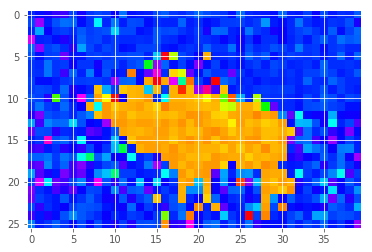

151 tensor(0.1195, device='cuda:4', grad_fn=<DivBackward0>) 1.123296114272027
152 tensor(0.1231, device='cuda:4', grad_fn=<DivBackward0>) 0.689329737184526
153 tensor(0.1227, device='cuda:4', grad_fn=<DivBackward0>) 0.9296040850187672
154 tensor(0.1216, device='cuda:4', grad_fn=<DivBackward0>) 0.8922019406950029
155 tensor(0.1188, device='cuda:4', grad_fn=<DivBackward0>) 1.2469438852488453
156 tensor(0.1330, device='cuda:4', grad_fn=<DivBackward0>) 1.4491464236294633
157 tensor(0.1257, device='cuda:4', grad_fn=<DivBackward0>) 1.6626338500364364
158 tensor(0.1284, device='cuda:4', grad_fn=<DivBackward0>) 1.8695775011982174
159 tensor(0.1251, device='cuda:4', grad_fn=<DivBackward0>) 0.9015586266496514
160 tensor(0.1874, device='cuda:4', grad_fn=<DivBackward0>) 2.927889436188653
161 tensor(0.1183, device='cuda:4', grad_fn=<DivBackward0>) 0.9552958786080278
162 tensor(0.1190, device='cuda:4', grad_fn=<DivBackward0>) 0.7330042834039955
163 tensor(0.1282, device='cuda:4', grad_fn=<DivBackwar

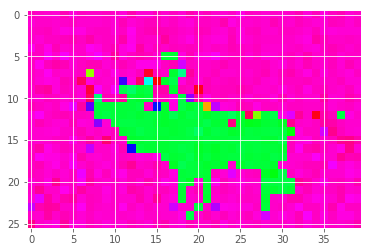

176 tensor(0.1080, device='cuda:4', grad_fn=<DivBackward0>) 0.6499258851018936
177 tensor(0.1113, device='cuda:4', grad_fn=<DivBackward0>) 0.5983599009768076
178 tensor(0.1220, device='cuda:4', grad_fn=<DivBackward0>) 1.2879800917438105
179 tensor(0.1029, device='cuda:4', grad_fn=<DivBackward0>) 0.6167825810904108
180 tensor(0.1057, device='cuda:4', grad_fn=<DivBackward0>) 0.8904315245483884
181 tensor(0.1087, device='cuda:4', grad_fn=<DivBackward0>) 0.4673916711369928
182 tensor(0.0998, device='cuda:4', grad_fn=<DivBackward0>) 0.7400229977147388
183 tensor(0.1053, device='cuda:4', grad_fn=<DivBackward0>) 0.2659754828840475
184 tensor(0.1087, device='cuda:4', grad_fn=<DivBackward0>) 0.6923652100118702
185 tensor(0.1028, device='cuda:4', grad_fn=<DivBackward0>) 0.6858129720095657
186 tensor(0.0993, device='cuda:4', grad_fn=<DivBackward0>) 1.1196846438056032
187 tensor(0.1054, device='cuda:4', grad_fn=<DivBackward0>) 0.3732425681743177
188 tensor(0.1045, device='cuda:4', grad_fn=<DivBack

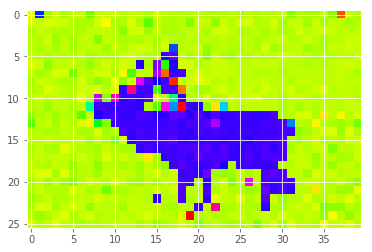

201 tensor(0.0968, device='cuda:4', grad_fn=<DivBackward0>) 0.48052008687885606
202 tensor(0.1028, device='cuda:4', grad_fn=<DivBackward0>) 1.3195250989190133
203 tensor(0.1041, device='cuda:4', grad_fn=<DivBackward0>) 0.7669476906922502
204 tensor(0.0968, device='cuda:4', grad_fn=<DivBackward0>) 1.0887188558236196
205 tensor(0.1004, device='cuda:4', grad_fn=<DivBackward0>) 0.6474316375724423
206 tensor(0.1011, device='cuda:4', grad_fn=<DivBackward0>) 0.7390213254474232
207 tensor(0.1014, device='cuda:4', grad_fn=<DivBackward0>) 0.6930431495379298
208 tensor(0.1008, device='cuda:4', grad_fn=<DivBackward0>) 0.44785412844868944
209 tensor(0.0995, device='cuda:4', grad_fn=<DivBackward0>) 0.8382220167861711
210 tensor(0.1004, device='cuda:4', grad_fn=<DivBackward0>) 0.7714211332545073
211 tensor(0.0956, device='cuda:4', grad_fn=<DivBackward0>) 0.3241137381482966
212 tensor(0.0970, device='cuda:4', grad_fn=<DivBackward0>) 0.9693971977608556
213 tensor(0.1010, device='cuda:4', grad_fn=<DivBa

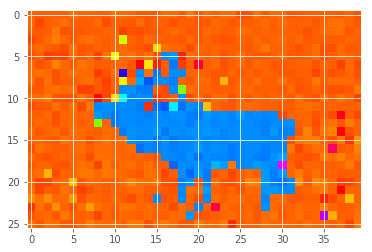

226 tensor(0.0931, device='cuda:4', grad_fn=<DivBackward0>) 0.454605565971542
227 tensor(0.0932, device='cuda:4', grad_fn=<DivBackward0>) 0.1848484312382381
228 tensor(0.0914, device='cuda:4', grad_fn=<DivBackward0>) 0.33901021733350617
229 tensor(0.0951, device='cuda:4', grad_fn=<DivBackward0>) 0.4676928244765243
230 tensor(0.0956, device='cuda:4', grad_fn=<DivBackward0>) 0.2898894915356132
231 tensor(0.0940, device='cuda:4', grad_fn=<DivBackward0>) 0.27580847782428497
232 tensor(0.0973, device='cuda:4', grad_fn=<DivBackward0>) 1.0394578209305825
233 tensor(0.0965, device='cuda:4', grad_fn=<DivBackward0>) 0.35549230363928946
234 tensor(0.0945, device='cuda:4', grad_fn=<DivBackward0>) 0.7719547826895357
235 tensor(0.0959, device='cuda:4', grad_fn=<DivBackward0>) 0.7179948355743325
236 tensor(0.1005, device='cuda:4', grad_fn=<DivBackward0>) 0.27373957910433017
237 tensor(0.0943, device='cuda:4', grad_fn=<DivBackward0>) 1.020223044430334
238 tensor(0.0946, device='cuda:4', grad_fn=<DivBa

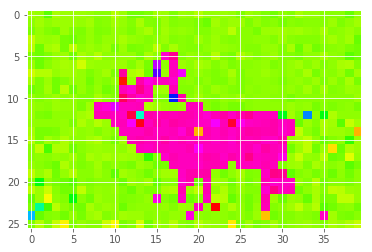

251 tensor(0.0951, device='cuda:4', grad_fn=<DivBackward0>) 0.995741581490855
252 tensor(0.0954, device='cuda:4', grad_fn=<DivBackward0>) 1.1236886274244353
253 tensor(0.0956, device='cuda:4', grad_fn=<DivBackward0>) 0.3087849688755891
254 tensor(0.0923, device='cuda:4', grad_fn=<DivBackward0>) 0.28009898634636954
255 tensor(0.0989, device='cuda:4', grad_fn=<DivBackward0>) 1.7186272436092285
256 tensor(0.0938, device='cuda:4', grad_fn=<DivBackward0>) 0.36856091553051057
257 tensor(0.0960, device='cuda:4', grad_fn=<DivBackward0>) 1.4777446523510394
258 tensor(0.0992, device='cuda:4', grad_fn=<DivBackward0>) 0.7969065856118485
259 tensor(0.0915, device='cuda:4', grad_fn=<DivBackward0>) 0.37520668034474197
260 tensor(0.0956, device='cuda:4', grad_fn=<DivBackward0>) 0.3665746967683531
261 tensor(0.0972, device='cuda:4', grad_fn=<DivBackward0>) 1.0192737238743896
262 tensor(0.0920, device='cuda:4', grad_fn=<DivBackward0>) 0.8208652080498583
263 tensor(0.0909, device='cuda:4', grad_fn=<DivBa

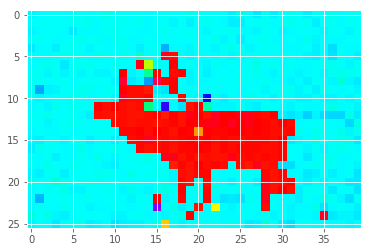

276 tensor(0.0964, device='cuda:4', grad_fn=<DivBackward0>) 0.27715263166440757
277 tensor(0.0905, device='cuda:4', grad_fn=<DivBackward0>) 0.40039841985114427
278 tensor(0.0944, device='cuda:4', grad_fn=<DivBackward0>) 0.7749091289793775
279 tensor(0.0948, device='cuda:4', grad_fn=<DivBackward0>) 0.18118106984295035
280 tensor(0.0929, device='cuda:4', grad_fn=<DivBackward0>) 0.4381103526729886
281 tensor(0.0907, device='cuda:4', grad_fn=<DivBackward0>) 0.6202111508741888
282 tensor(0.0915, device='cuda:4', grad_fn=<DivBackward0>) 0.3832750279612
283 tensor(0.0941, device='cuda:4', grad_fn=<DivBackward0>) 1.038226918339643
284 tensor(0.0920, device='cuda:4', grad_fn=<DivBackward0>) 0.06319368272321706
285 tensor(0.0934, device='cuda:4', grad_fn=<DivBackward0>) 0.2557669850301718
286 tensor(0.0895, device='cuda:4', grad_fn=<DivBackward0>) 0.39282837953249217
287 tensor(0.0917, device='cuda:4', grad_fn=<DivBackward0>) 0.4484117399870627
288 tensor(0.0944, device='cuda:4', grad_fn=<DivBac

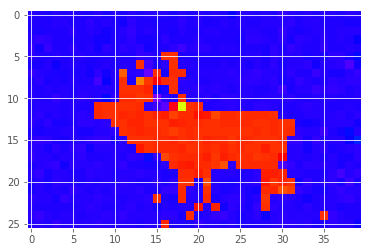

301 tensor(0.0920, device='cuda:4', grad_fn=<DivBackward0>) 0.23809030494319555
302 tensor(0.0907, device='cuda:4', grad_fn=<DivBackward0>) 0.4158883353221822
303 tensor(0.0921, device='cuda:4', grad_fn=<DivBackward0>) 0.28449692675761085
304 tensor(0.0916, device='cuda:4', grad_fn=<DivBackward0>) 0.1645345483261448
305 tensor(0.0895, device='cuda:4', grad_fn=<DivBackward0>) 0.3077660784073287
306 tensor(0.0942, device='cuda:4', grad_fn=<DivBackward0>) 0.49996600078757236
307 tensor(0.0924, device='cuda:4', grad_fn=<DivBackward0>) 0.492054003182592
308 tensor(0.0889, device='cuda:4', grad_fn=<DivBackward0>) 0.33330587659659744
309 tensor(0.0946, device='cuda:4', grad_fn=<DivBackward0>) 0.25547897651957224
310 tensor(0.0905, device='cuda:4', grad_fn=<DivBackward0>) 0.3367160898000836
311 tensor(0.0971, device='cuda:4', grad_fn=<DivBackward0>) 0.2526757396695823
312 tensor(0.0949, device='cuda:4', grad_fn=<DivBackward0>) 0.5462940355710384
313 tensor(0.0901, device='cuda:4', grad_fn=<Div

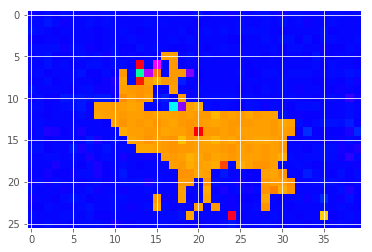

326 tensor(0.0900, device='cuda:4', grad_fn=<DivBackward0>) 0.09605188888249833
327 tensor(0.0889, device='cuda:4', grad_fn=<DivBackward0>) 0.29262263601093585
328 tensor(0.0920, device='cuda:4', grad_fn=<DivBackward0>) 0.2821015021869817
329 tensor(0.0937, device='cuda:4', grad_fn=<DivBackward0>) 0.22111428780226053
330 tensor(0.0930, device='cuda:4', grad_fn=<DivBackward0>) 0.360718805575406
331 tensor(0.0927, device='cuda:4', grad_fn=<DivBackward0>) 0.46075337982949555
332 tensor(0.0904, device='cuda:4', grad_fn=<DivBackward0>) 0.3505135161174456
333 tensor(0.0913, device='cuda:4', grad_fn=<DivBackward0>) 0.250016517163024
334 tensor(0.0928, device='cuda:4', grad_fn=<DivBackward0>) 0.1576458160696425
335 tensor(0.0896, device='cuda:4', grad_fn=<DivBackward0>) 0.2299915220135735
336 tensor(0.0900, device='cuda:4', grad_fn=<DivBackward0>) 0.46447254500013774
337 tensor(0.0902, device='cuda:4', grad_fn=<DivBackward0>) 0.1634685830986267
338 tensor(0.0897, device='cuda:4', grad_fn=<DivB

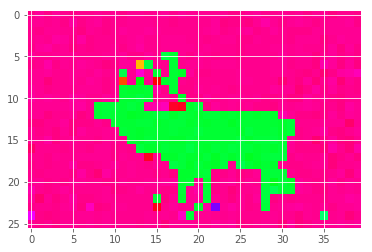

351 tensor(0.0892, device='cuda:4', grad_fn=<DivBackward0>) 0.407194667702077
352 tensor(0.0944, device='cuda:4', grad_fn=<DivBackward0>) 0.10060885544583983
353 tensor(0.0914, device='cuda:4', grad_fn=<DivBackward0>) 0.48125660658870045
354 tensor(0.0895, device='cuda:4', grad_fn=<DivBackward0>) 0.5558598563316988
355 tensor(0.0913, device='cuda:4', grad_fn=<DivBackward0>) 0.10060208820391087
356 tensor(0.0901, device='cuda:4', grad_fn=<DivBackward0>) 0.4444105409120199
357 tensor(0.0885, device='cuda:4', grad_fn=<DivBackward0>) 0.12441335783324967
358 tensor(0.0910, device='cuda:4', grad_fn=<DivBackward0>) 0.39844577294117633
359 tensor(0.0885, device='cuda:4', grad_fn=<DivBackward0>) 0.26190712989652565
360 tensor(0.0898, device='cuda:4', grad_fn=<DivBackward0>) 0.13603408109157486
361 tensor(0.0901, device='cuda:4', grad_fn=<DivBackward0>) 0.8155011689891155
362 tensor(0.0890, device='cuda:4', grad_fn=<DivBackward0>) 0.3131428606043707
363 tensor(0.0886, device='cuda:4', grad_fn=<D

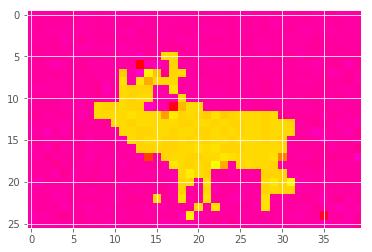

376 tensor(0.0891, device='cuda:4', grad_fn=<DivBackward0>) 0.17561263962241158
377 tensor(0.0886, device='cuda:4', grad_fn=<DivBackward0>) 0.5242995417318892
378 tensor(0.0899, device='cuda:4', grad_fn=<DivBackward0>) 0.6871521447453657
379 tensor(0.0913, device='cuda:4', grad_fn=<DivBackward0>) 0.1364630620159126
380 tensor(0.0881, device='cuda:4', grad_fn=<DivBackward0>) 0.1315872315008349
381 tensor(0.0884, device='cuda:4', grad_fn=<DivBackward0>) 0.41143012946897967
382 tensor(0.1012, device='cuda:4', grad_fn=<DivBackward0>) 1.564428012141371
383 tensor(0.0878, device='cuda:4', grad_fn=<DivBackward0>) 0.23514471672115783
384 tensor(0.0911, device='cuda:4', grad_fn=<DivBackward0>) 0.19223467749205408
385 tensor(0.0920, device='cuda:4', grad_fn=<DivBackward0>) 0.5464180159715918
386 tensor(0.0885, device='cuda:4', grad_fn=<DivBackward0>) 0.27498703641207495
387 tensor(0.0891, device='cuda:4', grad_fn=<DivBackward0>) 0.3642106898630446
388 tensor(0.0898, device='cuda:4', grad_fn=<Div

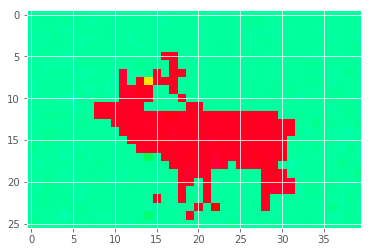

401 tensor(0.0870, device='cuda:4', grad_fn=<DivBackward0>) 0.41145847503190397
402 tensor(0.0913, device='cuda:4', grad_fn=<DivBackward0>) 0.6129341949581836
403 tensor(0.0906, device='cuda:4', grad_fn=<DivBackward0>) 0.22311271319315057
404 tensor(0.0901, device='cuda:4', grad_fn=<DivBackward0>) 0.2267056367812743
405 tensor(0.0897, device='cuda:4', grad_fn=<DivBackward0>) 0.18302236160575083
406 tensor(0.0897, device='cuda:4', grad_fn=<DivBackward0>) 0.19361020628704947
407 tensor(0.0892, device='cuda:4', grad_fn=<DivBackward0>) 0.04712120420613231
408 tensor(0.0890, device='cuda:4', grad_fn=<DivBackward0>) 0.4905194514816934
409 tensor(0.0916, device='cuda:4', grad_fn=<DivBackward0>) 0.14826017475283768
410 tensor(0.0912, device='cuda:4', grad_fn=<DivBackward0>) 0.3449943914482839
411 tensor(0.0904, device='cuda:4', grad_fn=<DivBackward0>) 0.6732037498614535
412 tensor(0.0893, device='cuda:4', grad_fn=<DivBackward0>) 0.6882666221769829
413 tensor(0.0894, device='cuda:4', grad_fn=<D

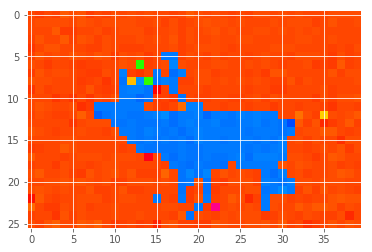

426 tensor(0.0904, device='cuda:4', grad_fn=<DivBackward0>) 0.16625285443141713
427 tensor(0.0896, device='cuda:4', grad_fn=<DivBackward0>) 0.37222676284705114
428 tensor(0.0883, device='cuda:4', grad_fn=<DivBackward0>) 0.19186000379302923
429 tensor(0.0890, device='cuda:4', grad_fn=<DivBackward0>) 0.470072835770028
430 tensor(0.0886, device='cuda:4', grad_fn=<DivBackward0>) 0.26503816822483445
431 tensor(0.0875, device='cuda:4', grad_fn=<DivBackward0>) 0.3201894670722136
432 tensor(0.0882, device='cuda:4', grad_fn=<DivBackward0>) 0.36576133426686064
433 tensor(0.0859, device='cuda:4', grad_fn=<DivBackward0>) 0.0865479620377761
434 tensor(0.0897, device='cuda:4', grad_fn=<DivBackward0>) 0.2086642107107751
435 tensor(0.0878, device='cuda:4', grad_fn=<DivBackward0>) 0.0518991347324485
436 tensor(0.0884, device='cuda:4', grad_fn=<DivBackward0>) 0.42892343674081224
437 tensor(0.0902, device='cuda:4', grad_fn=<DivBackward0>) 0.105544520617811
438 tensor(0.0919, device='cuda:4', grad_fn=<Div

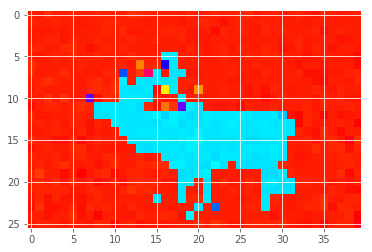

451 tensor(0.0876, device='cuda:4', grad_fn=<DivBackward0>) 0.10811582144539594
452 tensor(0.0876, device='cuda:4', grad_fn=<DivBackward0>) 0.23096938177596163
453 tensor(0.0880, device='cuda:4', grad_fn=<DivBackward0>) 0.05519281741631988
454 tensor(0.0867, device='cuda:4', grad_fn=<DivBackward0>) 0.1341401618842372
455 tensor(0.0876, device='cuda:4', grad_fn=<DivBackward0>) 0.4609515342914181
456 tensor(0.0910, device='cuda:4', grad_fn=<DivBackward0>) 0.14055074084335953
457 tensor(0.0898, device='cuda:4', grad_fn=<DivBackward0>) 0.22228098260497625
458 tensor(0.0893, device='cuda:4', grad_fn=<DivBackward0>) 0.1870476027670264
459 tensor(0.0880, device='cuda:4', grad_fn=<DivBackward0>) 0.4373419900319601
460 tensor(0.0869, device='cuda:4', grad_fn=<DivBackward0>) 0.15952179741738104
461 tensor(0.0907, device='cuda:4', grad_fn=<DivBackward0>) 0.18002979898834548
462 tensor(0.0871, device='cuda:4', grad_fn=<DivBackward0>) 0.06688759377841945
463 tensor(0.0899, device='cuda:4', grad_fn=

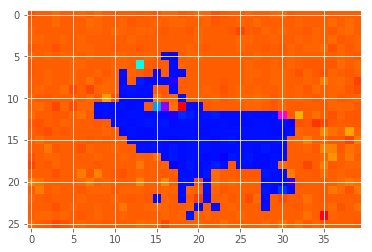

476 tensor(0.0883, device='cuda:4', grad_fn=<DivBackward0>) 0.31392933804366896
477 tensor(0.0903, device='cuda:4', grad_fn=<DivBackward0>) 0.14039471843601373
478 tensor(0.0887, device='cuda:4', grad_fn=<DivBackward0>) 0.2795820712342797
479 tensor(0.0894, device='cuda:4', grad_fn=<DivBackward0>) 0.26804674794640837
480 tensor(0.0885, device='cuda:4', grad_fn=<DivBackward0>) 0.4245546652340321
481 tensor(0.0897, device='cuda:4', grad_fn=<DivBackward0>) 0.4966893852475651
482 tensor(0.0876, device='cuda:4', grad_fn=<DivBackward0>) 0.49949323513980953
483 tensor(0.0877, device='cuda:4', grad_fn=<DivBackward0>) 0.05019768687011125
484 tensor(0.0902, device='cuda:4', grad_fn=<DivBackward0>) 0.4416295854807266
485 tensor(0.0890, device='cuda:4', grad_fn=<DivBackward0>) 0.27017172806844425
486 tensor(0.0899, device='cuda:4', grad_fn=<DivBackward0>) 0.3810798597772852
487 tensor(0.0877, device='cuda:4', grad_fn=<DivBackward0>) 0.20870671959937942
488 tensor(0.0891, device='cuda:4', grad_fn=<

In [29]:
seed=3
np.random.seed(seed)
torch.manual_seed(seed)
num_classes = y.shape[0]
max_loss = 1 + .5 * num_classes * (1. / np.arange(1, num_classes + 1)**2)[:int(num_classes / 2.)].sum()
for epoch in range(num_epochs):
    phases = net(x, h=x.shape[-2], w=x.shape[-1], alpha=alpha, burnin_steps=burnin_steps,
                 num_steps=num_steps, subset_size=subset_size, enable_noise=False, record_loss=False)
    b, c, h, w = phases.size()
    loss, synch, desynch = circular_moments_batch(phases.view(b, c, -1).squeeze(), y, split=True)
#     loss, synch, desynch = cohn_loss(phases.view(b, c, -1), y, burn_in_prop=0, split=True)

#     loss = loss / num_steps
#     loss = loss / max_loss
    optim.zero_grad()
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
    print(epoch, loss/max_loss, norm)
    optim.step()
    if epoch % 25 == 0:
        plt.figure()
        plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
#         plt.savefig('%d.png' % epoch)
        plt.show()
        plt.close()
#         print(epoch, loss.item(), synch.item(), desynch.item(), norm.item())

In [16]:
torch.save(net.state_dict(), '/media/data_cifs/projects/prj_synchrony/results/models/gray_elk_net.pt')

321 481


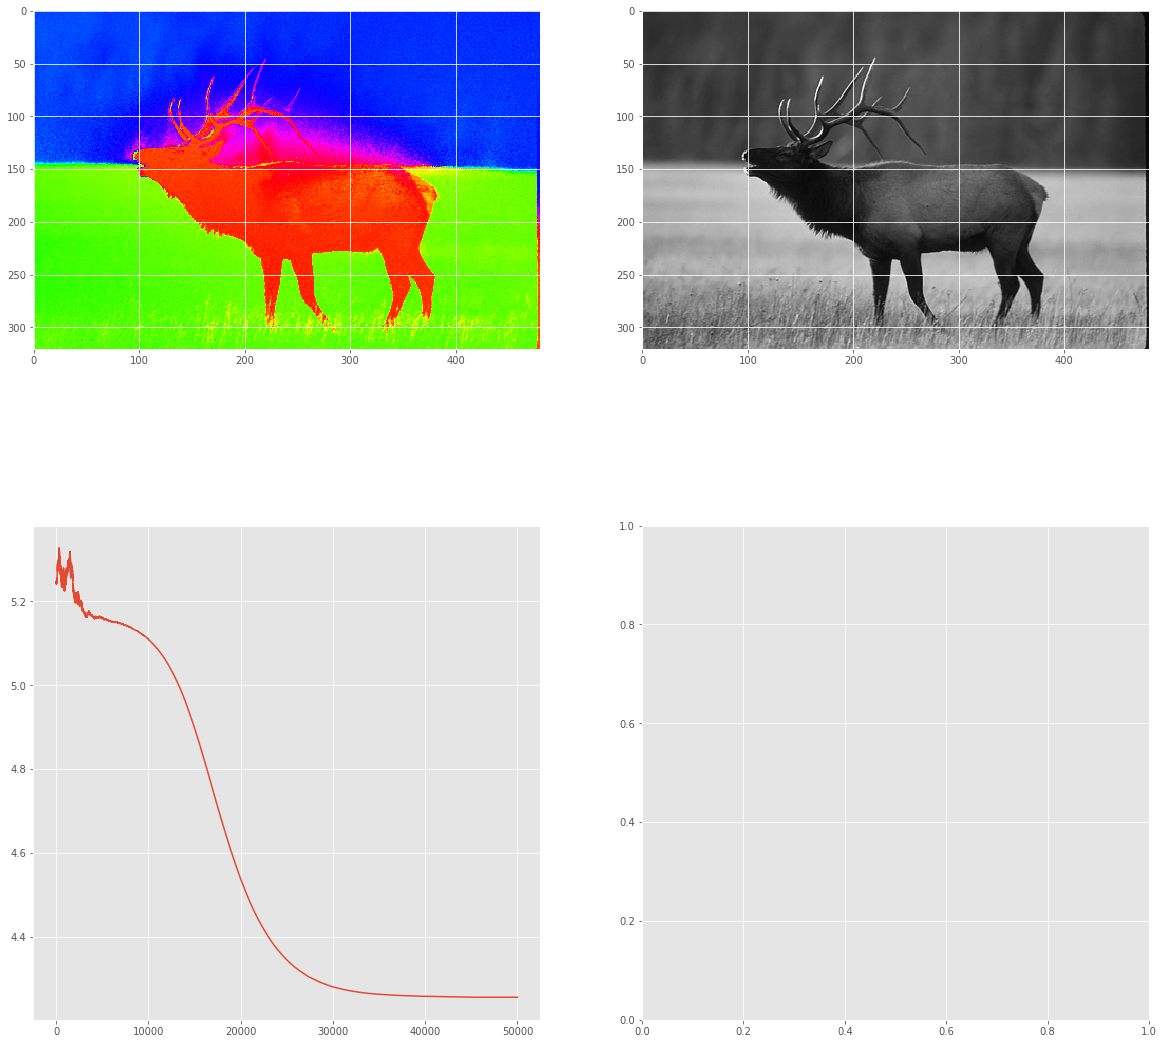

In [27]:
# run Kuramoto dynamics over 1000 steps (200 steps for training)
import ipdb
h, w, _ = img.shape
print(h,w)
s = 1
_sm_img = cv.resize(img, (w//s, h//s))
_sm_seg = cv.resize(segs[2], (w//s, h//s))

_x = torch.Tensor(_sm_img).to(device) / 255.
_x = _x.permute(2,0,1).unsqueeze(0)
lb = LabelBinarizer()
label = _sm_seg.reshape(-1)
label_bin = lb.fit_transform(label)

label_bin[:,2]=0
label_bin = np.concatenate([label_bin[:,:2], label_bin[:,3:]],axis=1)
y = torch.Tensor(label_bin).to(device)
y = y.transpose(0,1)

_x_gray = _x.mean(1).unsqueeze(1).repeat(1,3,1,1)
with torch.no_grad():
    phases = net(_x_gray, alpha=.5*alpha, h=_sm_img.shape[0], w=_sm_img.shape[1], init_phase=None,
                 burnin_steps=0, num_steps=50000, enable_noise=False, record_trajectory=False, record_loss=True, labels=y)

# b, c = phases.shape[:2]
fig, axes = plt.subplots(2,2,figsize=(20,20))
axes[0,0].imshow(phases[0,...].reshape(h//s,w//s).cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
axes[0,1].imshow(_x_gray[0,0,...].cpu().numpy(), cmap=plt.get_cmap('gray'))
axes[1,0].plot(net.dyn_loss)
# axes[1,1].bar(np.linspace(-.5,.5,100000),net.coupling_density)
plt.show()
plt.close()
# print(latent_phases.shape)
# plt.figure()
# phase_evol_ax(ax, (phases).view(b, c, -1).cpu().data.numpy(), y.cpu().data.numpy())

In [116]:
init_phase = phases.reshape(1,-1)

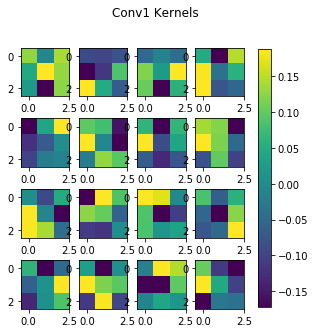

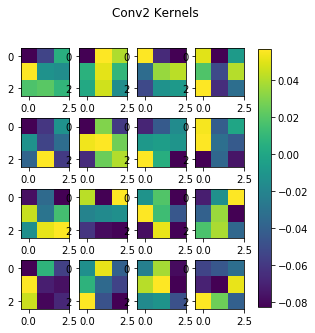

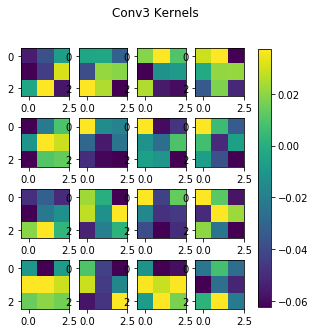

In [24]:

conv1 = net.features[0].weight.detach().cpu().numpy()
conv2 = net.features[2].weight.detach().cpu().numpy()
conv3 = net.features[4].weight.detach().cpu().numpy()

for c, conv in enumerate([conv1, conv2, conv3]):
    fig, axes = plt.subplots(4,4,figsize=(5,5))
    for a, ax in enumerate(axes.reshape(-1)):
        im = ax.imshow(conv[a,0,...])
    plt.suptitle('Conv{} Kernels'.format(c + 1))
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    plt.show()
    plt.close()

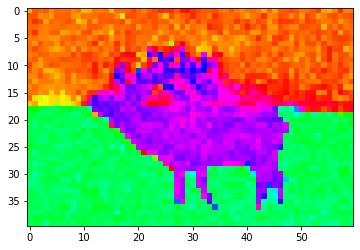

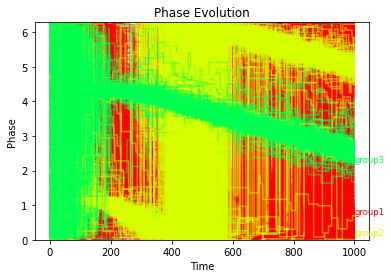

<Figure size 432x288 with 0 Axes>

In [75]:
# converting grayscale
with torch.no_grad():
#     phases = net(torch.flip(x,dims=[3]), alpha=alpha, burnin_steps=0, num_steps=1000, enable_noise=False)
    phases = net(x.mean(1,keepdim=True).repeat(1,3,1,1), h=40, w=60, alpha=alpha, burnin_steps=0, num_steps=1000, subset_size=128, enable_noise=False)

b, c = phases.shape[:2]
plt.figure()
plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
plt.show()
plt.close()
fig, ax = plt.subplots()
# print(latent_phases.shape)
plt.figure()
phase_evol_ax(ax, (phases).view(b, c, -1).cpu().data.numpy(), y.cpu().data.numpy())

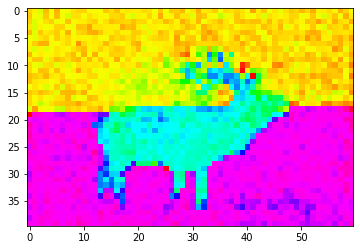

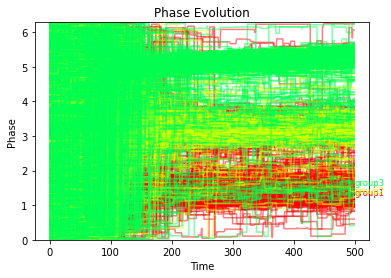

<Figure size 432x288 with 0 Axes>

In [74]:
# horizontal flipping
with torch.no_grad():
    phases = net(torch.flip(x,dims=[3]), h=40, w=60, alpha=alpha, burnin_steps=0, num_steps=500, subset_size=128, enable_noise=False)

b, c = phases.shape[:2]
plt.figure()
plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
plt.show()
plt.close()
fig, ax = plt.subplots()
# print(latent_phases.shape)
plt.figure()
phase_evol_ax(ax, (phases).view(b, c, -1).cpu().data.numpy(), y.cpu().data.numpy())

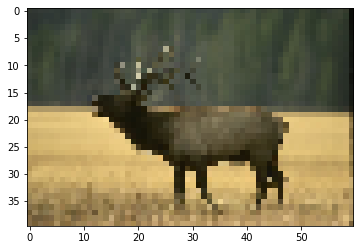

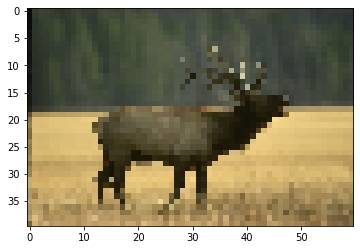

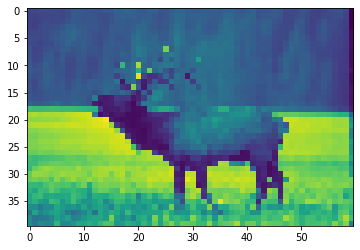

In [49]:
plt.figure()
plt.imshow(x[0].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(torch.flip(x,dims=[3])[0].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(x.mean(1,keepdim=True)[0].permute(1,2,0).cpu().numpy())